In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from LJhelpers import *

In [2]:
# Parameters for trust region
tol = 1e-6 # stop iterations when ||grad f|| < tol
iter_max = 200 # maximal number of iterations
Delta_max = 5 # max trust region radius
Delta_min = 1e-12 # minimal trust region radius
eta = 0.1 # step rejection parameter
subproblem_iter_max = 5 # max number of iterations for quadratic subproblems
tol_sub = 1e-1 # relative tolerance for the subproblem
rho_good = 0.75 # if rho > rho_good, increase trust region radius
rho_bad = 0.25 # if rho < rho_bad, decrease trust region radius

def cauchy_point(B, g, Delta):
    ng = np.linalg.norm(g)
    ps = -g * Delta / ng
    aux = np.dot(g, B @ g)
    if aux <= 0:
        p = ps
    else:
        a = np.minimum(ng**3 / (Delta * aux), 1)
        p = ps * a
    return p

In [3]:
# Delta = initial trust region radius
def trust_region(x, pot, grad, hess, Delta, verbose=False):
    # initialization
    f = pot(x)
    g = grad(x)
    norm_g = np.linalg.norm(g)
    if verbose:
        print(f'Initially, f = {f}, ||grad f|| = {norm_g}')

    fvals = [f]
    ngvals = [norm_g]
    xvals = [x]

    I = np.eye(np.size(x), dtype=float)

    # the main trust region cycle
    iter = 1
    while (norm_g > tol and iter < iter_max):
        # solve the constrained minimization problem
        B = hess(x)
        flag_boundary = 0
        # check if B is SPD
        eval_min = np.amin(np.real(scipy.linalg.eig(B, b=None, left=False, right=False)))
        j_sub = 0
        if eval_min > 0: # B is SPD: B = R' * R, R' * R * p = -g
            p = scipy.linalg.solve(B, -g)
            p_norm = np.linalg.norm(p)
            if p_norm > Delta: # else: we are done with solving the subproblem
                flag_boundary = 1
        else:
            flag_boundary = 1
        if flag_boundary == 1: # solution lies on the boundary
            lam_min = np.maximum(-eval_min, 0.0)
            lam = lam_min + 1
            R = scipy.linalg.cholesky(B + lam * I, lower=False)
            flag_subproblem_success = 0
            while j_sub < subproblem_iter_max:
                j_sub += 1
                p = scipy.linalg.solve_triangular(np.transpose(R), -g, lower=True)
                p = scipy.linalg.solve_triangular(R, p, lower=False)
                p_norm = np.linalg.norm(p)
                dd = np.absolute(p_norm - Delta)
                if dd < tol_sub * Delta:
                    flag_subproblem_success = 1
                    break
                q = scipy.linalg.solve_triangular(np.transpose(R), p, lower=True)
                q_norm = np.linalg.norm(q)
                dlam = (p_norm / q_norm)**2 * (p_norm - Delta) / Delta
                lam_new = lam + dlam
                if lam_new > lam_min:
                    lam = lam_new
                else:
                    lam = 0.5 * (lam + lam_min)
                R = scipy.linalg.cholesky(B + lam * I, lower=False)
            if flag_subproblem_success == 0:
                p = cauchy_point(B, g, Delta)
        # assess the progress
        xnew = x + p
        fnew = pot(xnew)
        gnew = grad(xnew)
        mnew = f + np.dot(g, p) + 0.5 * np.dot(p, B @ p)
        rho = (f - fnew) / (f - mnew + 1e-14)
        # adjust the trust region
        if rho < rho_bad:
            Delta = np.maximum(0.25 * Delta, Delta_min)
        else:
            if rho > rho_good and flag_boundary == 1:
                Delta = np.minimum(Delta_max, 2 * Delta)
        # accept or reject step
        if rho > eta: # accept step
            x = xnew
            f = fnew
            g = gnew
            norm_g = np.linalg.norm(g)
            if verbose:
                print(f'Accept: iter {iter}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}')
        else:
            if verbose:
                print(f'Reject: iter {iter}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}')

        fvals.append(f)
        ngvals.append(norm_g)
        xvals.append(x)
        iter += 1
    xvals = np.array(xvals)
    return fvals, ngvals, xvals

### 3. Minimizing Lennard-Jones Pair Potentials via Trust Region

In [4]:
# Four local minima of LJ7:
# f1 = -16.50538417 Pentagonal bipyramid
# f2 = -15.93504306 Capped octahedron
# f3 = -15.59321094 Tricapped tetrahedron
# f4 = -15.53306005 Bicapped trigonal bipyramid

In [5]:
# model = 0, 1, 2, 3, or 4; 0 corresponds to a random initialization. 1--4 set the system up
# close to the corresponding local minima listed above.
def lj_minimize(Na, model):
  rstar = 2**(1 / 6) # minimizer of Lennard-Jones pair potential r^(-12) - r^(-6)
  xyz = initial_configuration(model, Na, rstar)
  x = remove_rotations_translations(xyz)
  fvals, ngvals, xvals = trust_region(x, LJpot, LJgrad, LJhess, 1)

  ax1 = plt.subplot(321)
  ax2 = plt.subplot(323)
  ax3 = plt.subplot(325)
  ax4 = plt.subplot(122, projection='3d')

  ax1.plot(range(len(fvals)), fvals, linewidth=2)
  ax1.set_xlabel('$k$')
  ax1.set_ylabel('$f_k$')

  ax2.plot(range(len(ngvals)), ngvals, linewidth=2)
  ax2.set_xlabel('$k$')
  ax2.set_ylabel('$||\\nabla f_k||$')
  ax2.set_yscale('log')

  H = LJhess(xvals[-1])
  evals = np.sort(np.linalg.eigvals(H))
  ax3.scatter(range(len(evals)), evals, s=20)
  ax3.set_xlabel('Index')
  ax3.set_ylabel('Eigenvalues of $H$')
  if evals[0] > 0:
      ax3.set_yscale('log')

  ax4.set_title(f'Final $f_k = {fvals[-1]:.8}$\nFinal $||\\nabla f_k||$ = {ngvals[-1]:.8}', loc='left')
  # TODO

  plt.suptitle(f'Lennard-Jones TODO Trust Region with Model {model}')
  plt.tight_layout()
  plt.show()

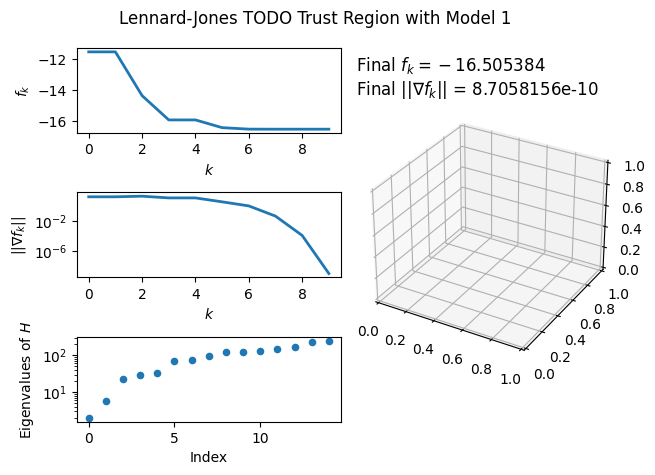

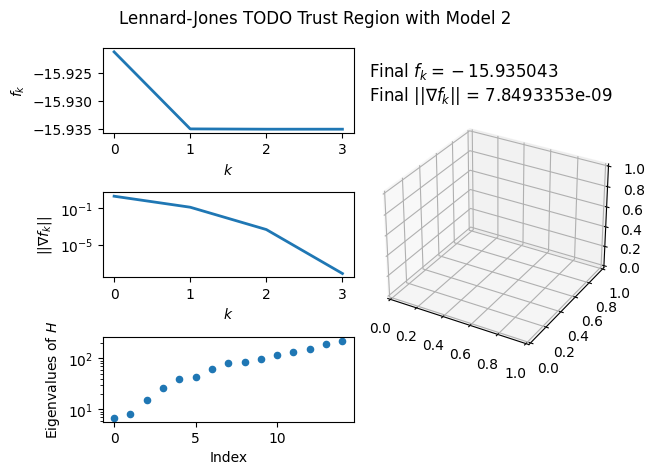

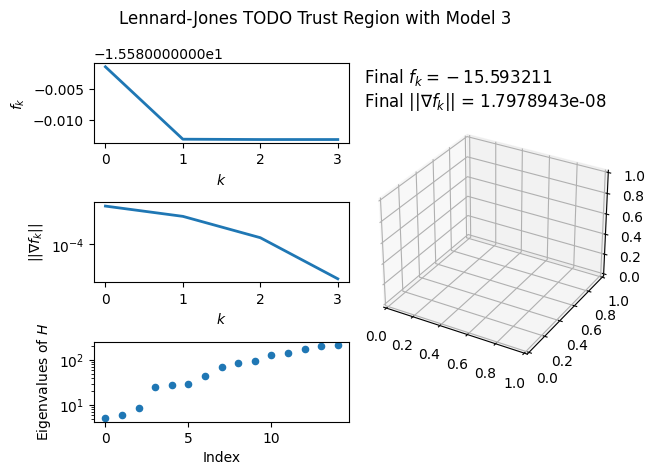

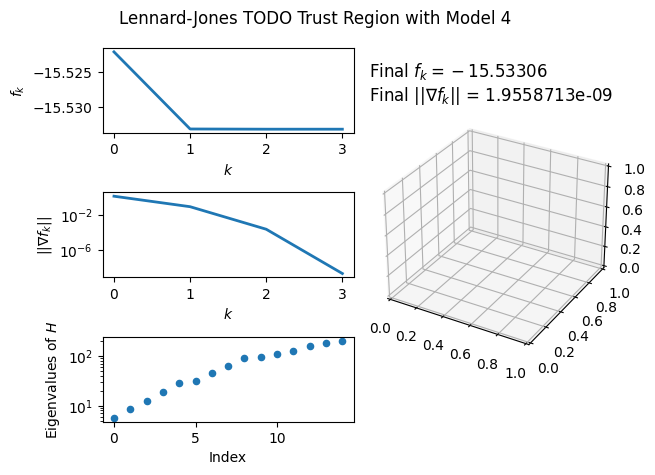

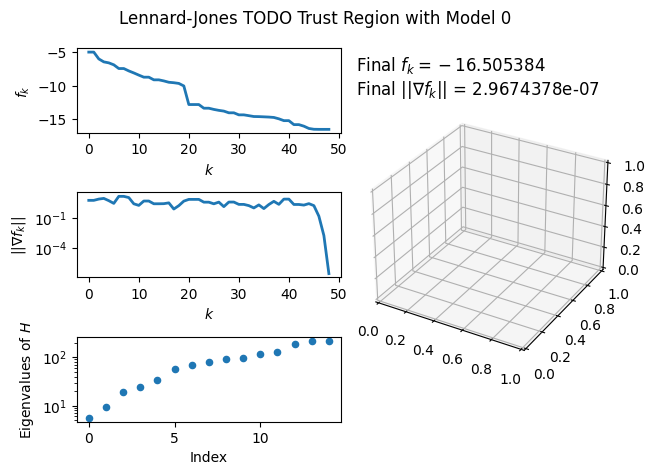

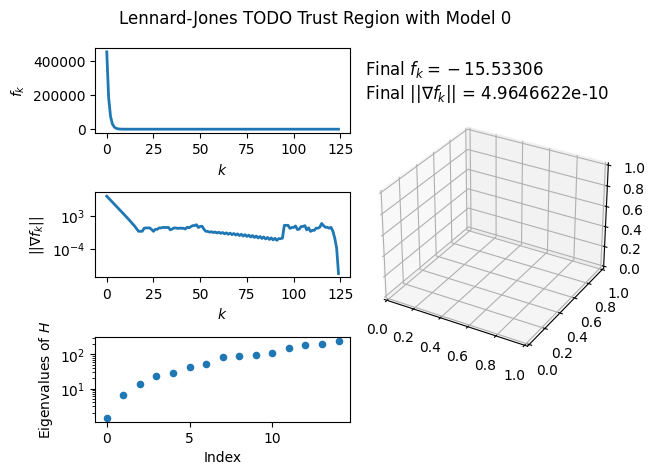

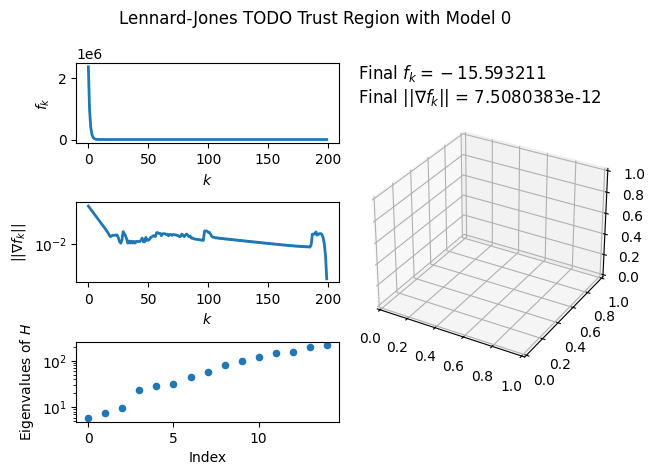

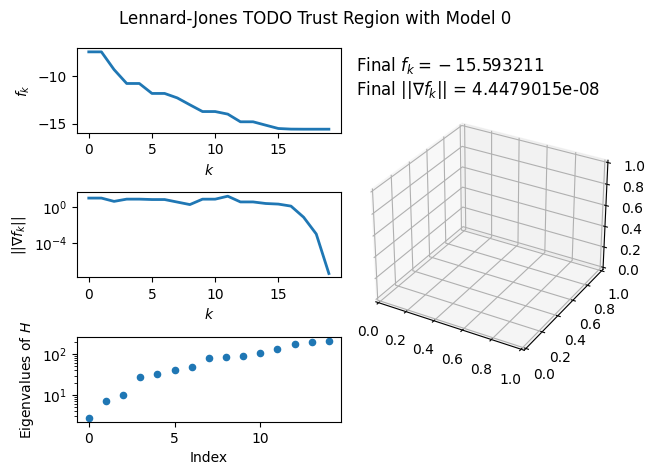

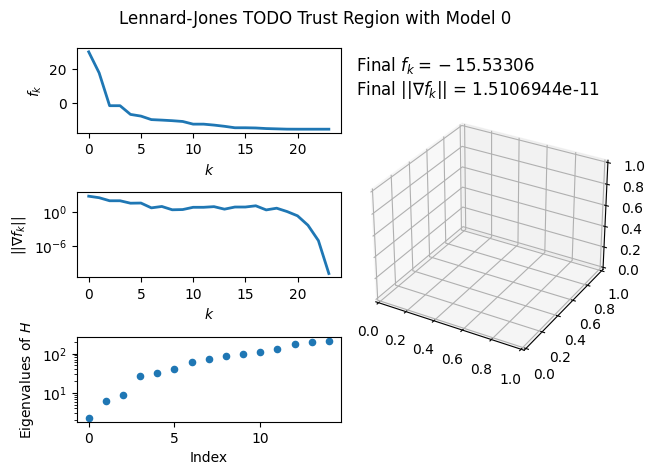

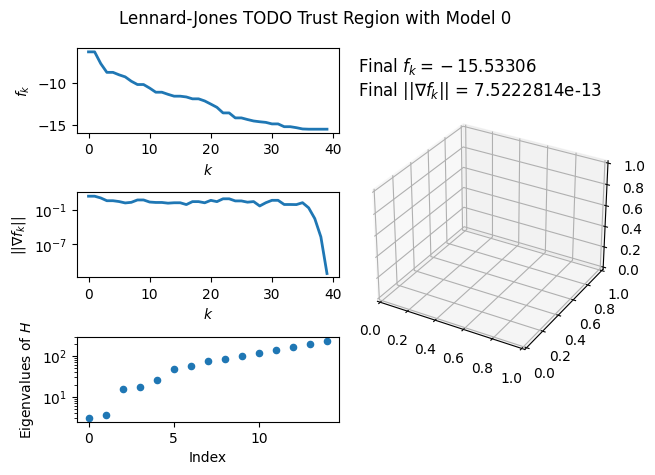

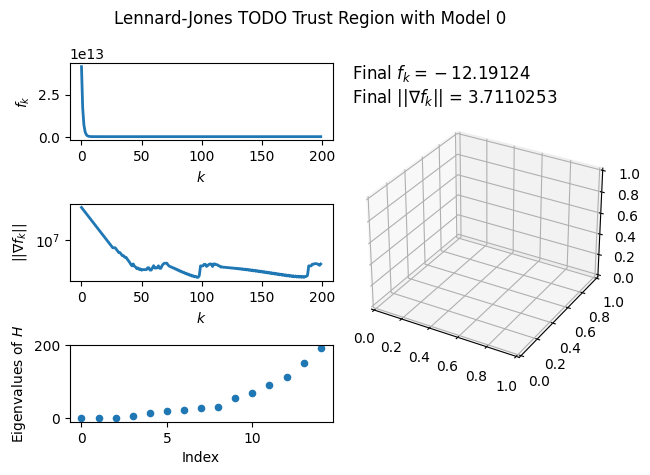

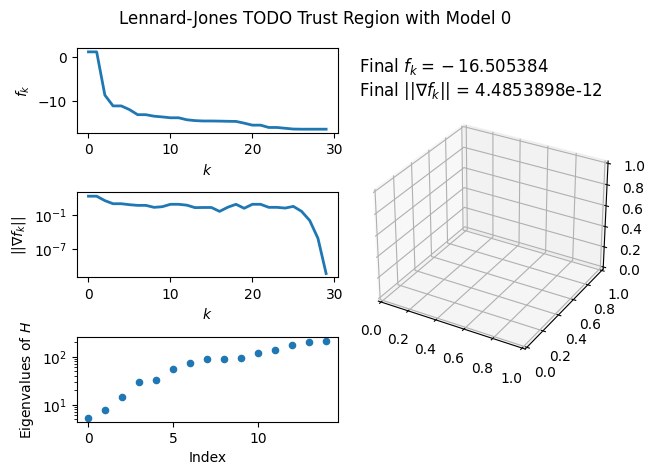

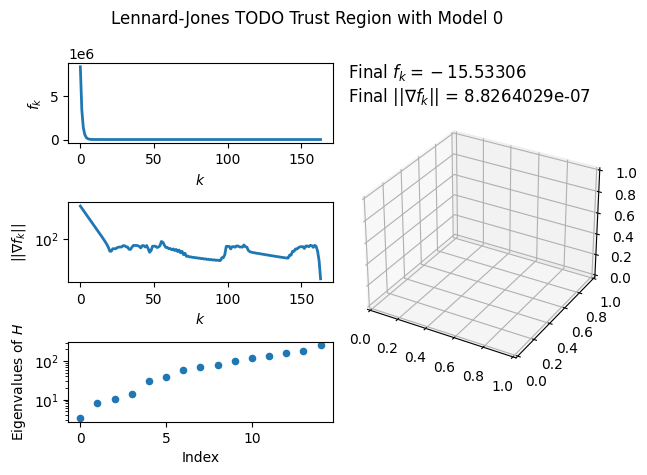

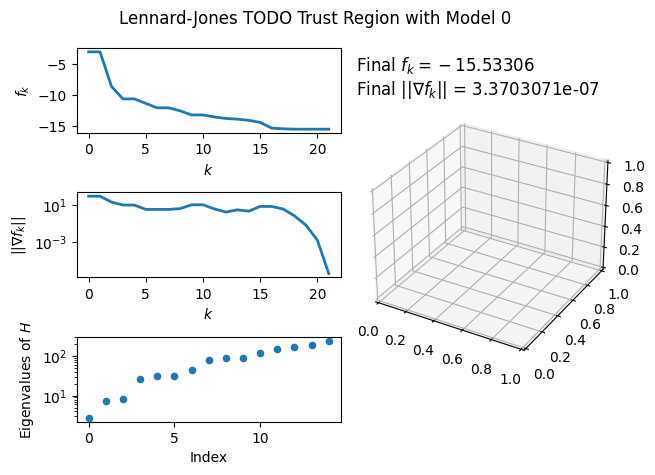

In [6]:
models = [1, 2, 3, 4] + 10 * [0]
for model in models:
  lj_minimize(7, model)

### 4. Minimizing Rosenbrock Function via Trust Region

In [7]:
def rosen_minimize(x):
  def rosen_pot(x):
    return 100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2

  def rosen_grad(x):
    return np.array([-400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0]), 200 * (x[1] - x[0]**2)])

  def rosen_hess(x):
    return np.array([[-400 * (x[1] - x[0]**2) + 800 * x[0]**2 + 2, -400 * x[0]],
                    [-400 * x[0], 200]])

  _, _, xs_newton = trust_region(x, rosen_pot, rosen_grad, rosen_hess, 1)
  _, _, xs_bfgs = trust_region(x, rosen_pot, rosen_grad, rosen_hess, 1)

  ax1 = plt.subplot(121)
  ax2 = plt.subplot(122)

  ax1.plot(range(len(xs_newton)), np.linalg.norm(xs_newton - [1, 1], axis=1), label='Newton')
  ax1.plot(range(len(xs_bfgs)), np.linalg.norm(xs_bfgs - [1, 1], axis=1), label='BFGS')
  ax1.set_xlabel('$k$')
  ax1.set_ylabel('$|| (x_k, y_k) - (x^*, y^*) ||$')
  ax1.set_yscale('log')
  ax1.legend()

  s = np.linspace(-1.5, 1.5, 100)
  X, Y = np.meshgrid(s, s)
  ax2.contour(X, Y, rosen_pot([X, Y]), levels=40, cmap=cm.gist_gray)
  ax2.plot(xs_newton[:, 0], xs_newton[:, 1])
  ax2.plot(xs_bfgs[:, 0], xs_bfgs[:, 1])
  ax2.set_xlabel('$x$')
  ax2.set_ylabel('$y$')

  plt.suptitle(f'Rosenbrock Trust Region with Initial {x}')
  plt.tight_layout()
  plt.show()

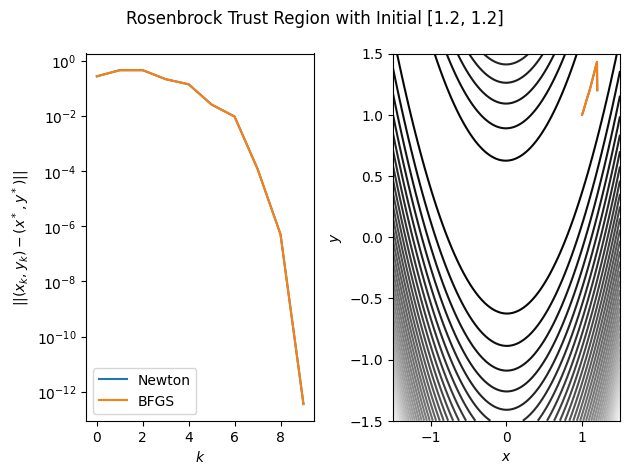

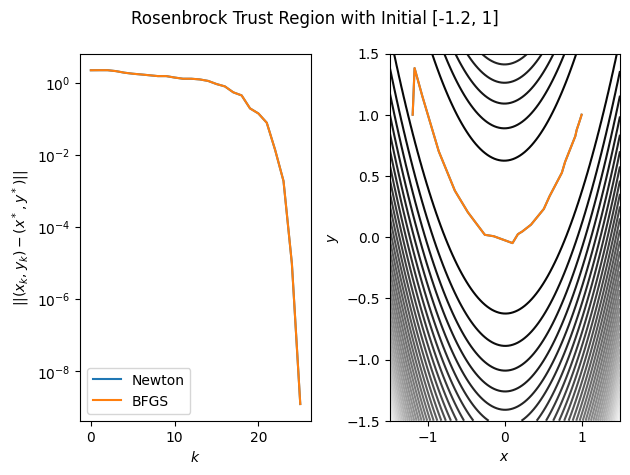

In [8]:
for x in [[1.2, 1.2], [-1.2, 1]]:
  rosen_minimize(x)